# Continuation of QC - milestone num. 5 - issue num. 2
CellBender recognised a lot of empty cells, since we've chosen to not use CellBender, and the most reasonable thing is that most of the TP detection of empty cells might be cells we classified stromal.

For this reason we will investigate stromal cells:
1. Comparing number of reads in stromal cells and immune/tumor cells.
2. After analysing the finding of the previous step we will decide whether to check for prominent overlap between stromal cell and cells classified empty by CellBender.  

28.2.21 Update:

3. plot, per sample, the number of genes expressed in each cell (i.e., absolute number of non-zero entries in each cell), and see if there's some left tail.

4. Also, please check which cells express the genes COL1A1 and COL1A2 which are common fibroblast genes, and see if they are generally expressed in cells with a higher gene count?


If this would still be unclear, we can follow the clustering scheme we talked about and I believe we will see all the problematic cells there.


In [1]:
import sys
lib = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities\droplet_dataset'
lib2 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities'
lib3 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\data_analysis'
lib4 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy'
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
import os
from os.path import join
import sklearn
from utilities.droplet_dataset import *
# from utilities import *
from matplotlib import pyplot
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import pickle
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd
import random
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
import time
import matplotlib.pyplot as plt
import copy
from scipy import stats
from sklearn.cluster import KMeans
from collections import Counter
from PIL import Image, ImageColor
from termcolor import colored
from sklearn.manifold import TSNE
from droplet_dataset import loading_sample
from DL.Mars_seq_DL.data_loading import extract_droplet_data_from_pickle

In [5]:
def extract_sample(sample_id):
    """
    Extracts one of the samples from PC
    :param sample_id: id of rna sample (Mi)
    :return: rna_sample
    """
    data_path = join(SAMPLES_INFORMATION_PATH, sample_id, f'{sample_id}.pkl')
    rna_sample = extract_droplet_data_from_pickle(data_path)
    print(colored(f'sample id {sample_id}', 'blue'))
    print(f'count shape {rna_sample.counts.shape}')
    print(f'number of cells {rna_sample.number_of_cells}')
    print(f'number of genes {rna_sample.number_of_genes}')
    return rna_sample

# 1. Comparing number of reads in stromal cells and immune/tumor cells:

In [4]:
ROW_SAMPLES_PATH = fr'D:\Technion studies\Keren Laboratory\Data\droplet_seq\ROW_DATA'
SAMPLES_INFORMATION_PATH = fr'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\4.3.21'


df = pd.DataFrame(columns=["sample", "immune&stromal_p_val", "immune_test", "tumor&stromal_p_val", "tumor_test",
                      'immune_mean', 'tumor_mean', 'stromal_mean',
                      'immune_median', 'tumor_median', 'stromal_median'])

samples = [subfolder.replace(".pkl", "") for subfolder in os.listdir(ROW_SAMPLES_PATH)]
# create_folder(OUTPUT_PATH)
for sample in [s for s in samples if not 'csv' in s]:
    
    # Extracts one of the samples from PC
    rna_sample = loading_sample(row_data_path=join(ROW_SAMPLES_PATH, f'{sample}.pkl'),
                                    cells_information_path=join(SAMPLES_INFORMATION_PATH, f'{sample}.pkl'))
    _rna_sample = RNAseq_Sample(counts=rna_sample.counts, gene_names=rna_sample.gene_names, barcodes=rna_sample.barcodes, 
                            features=rna_sample.features, cells_information=rna_sample.cells_information)
    rna_sample = _rna_sample  
    
    ###   Remove garbage cells  ###
    rna_sample = rna_sample[[not aa for aa in rna_sample.cells_information.getattr('should_be_removed')]]

    ###  Normalize cells  ###
    rna_sample.normalize_data()
    
    ###   Filter cancer/immune/stromal cells, two method, choose one  ###
    # first method: number of reads
    ss = rna_sample[rna_sample.cells_information.getattr('is_stromal')].counts.sum(axis=1)
    ii = rna_sample[rna_sample.cells_information.getattr('is_immune')].counts.sum(axis=1)
    tt = rna_sample[rna_sample.cells_information.getattr('is_cancer')].counts.sum(axis=1)

    # second method: number of genes expressed in each cell
#     ss = (rna_sample[rna_sample.cells_information.getattr('is_stromal')].counts>0).astype(np.int).sum(axis=1)
#     ii = (rna_sample[rna_sample.cells_information.getattr('is_immune')].counts>0).astype(np.int).sum(axis=1)
#     tt = (rna_sample[rna_sample.cells_information.getattr('is_cancer')].counts>0).astype(np.int).sum(axis=1)
    
    
    
    ###  Test distributions ###
    if stats.shapiro(ss)[1] < 0.05 or stats.shapiro(ii)[1] < 0.05:
        immune_stromal_p_val = scipy.stats.mannwhitneyu(ss, ii, alternative='less')[1]
        imm_test = "mannwhitneyu"
    else:
        immune_stromal_p_val = stats.ttest_ind(ss, ii, alternative='less')[1]
        imm_test = "ttest"

    if stats.shapiro(ss)[1] < 0.05 or stats.shapiro(tt)[1] < 0.05:
        tumor_stromal_p_val = scipy.stats.mannwhitneyu(ss, tt, alternative='less')[1]
        tu_test = "mannwhitneyu"
    else:
        tumor_stromal_p_val = stats.ttest_ind(ss, tt, alternative='less')[1]
        tu_test = "ttest"

    ###  Extract distribution attributes ###
    immune_mean = ii.mean()
    tumor_mean = tt.mean()
    stromal_mean = ss.mean()

    immune_median = np.median(ii)
    tumor_median = np.median(tt)
    stromal_median = np.median(ss)

    ###  Update DataFrame ###
    df = df.append(pd.DataFrame([[sample.replace('.pkl',''), 
                             immune_stromal_p_val, 
                             imm_test, 
                             tumor_stromal_p_val, 
                             tu_test,
                             immune_mean,
                            tumor_mean,
                            stromal_mean,
                            immune_median,
                            tumor_median,
                            stromal_median]],columns=df.columns))
df

,sample,immune&stromal_p_val,immune_test,tumor&stromal_p_val,tumor_test,immune_mean,tumor_mean,stromal_mean,immune_median,tumor_median,stromal_median
0,M100,1.006098e-29,mannwhitneyu,3.760629e-69,mannwhitneyu,2712.346273,3642.803756,1657.584214,2675.529838,3795.920799,1663.881107
0,M101,1.000000e+00,mannwhitneyu,6.687439e-27,mannwhitneyu,3282.483395,4024.210668,3523.262862,3153.109789,4161.472102,3805.331416
0,M102,8.454719e-138,mannwhitneyu,1.668708e-249,mannwhitneyu,2661.083188,2465.517649,2002.279656,2644.528959,2312.194892,1955.805265
0,M103,9.996590e-01,mannwhitneyu,3.387232e-02,mannwhitneyu,3262.400648,3587.185724,3362.959784,3216.679045,3719.724077,3690.270472
0,M104,3.191288e-25,mannwhitneyu,0.000000e+00,mannwhitneyu,2728.334285,4261.105948,2078.829307,2626.559544,4422.588058,1881.152425
0,M105,2.429001e-12,mannwhitneyu,5.609907e-126,mannwhitneyu,2110.304613,2986.523733,2033.207787,2078.353316,3183.659786,1826.487948
0,M106,1.000000e+00,mannwhitneyu,6.358338e-01,mannwhitneyu,2948.032855,3762.148353,3864.348521,2940.465019,3961.933994,4026.030990
0,M107,1.000000e+00,mannwhitneyu,6.086798e-01,mannwhitneyu,2777.489187,3366.102002,3220.215924,2774.396598,3447.099993,3550.074310
0,M108,8.466758e-02,mannwhitneyu,2.066784e-37,mannwhitneyu,1609.713753,2219.595858,1613.047859,1592.697964,2286.024848,1376.716226
0,M109,1.063181e-01,mannwhitneyu,1.257987e-77,mannwhitneyu,2351.382289,3620.015949,2380.050708,2234.198011,4053.463543,2206.811097


In [6]:
df.to_excel(r'D:\Technion studies\Keren Laboratory\python_playground\outputs\QC\QC_stromal_reads_distribution_4.3.21.xlsx', index='False')

# 2. Checking for prominent overlap between stromal cell and cells classified empty by CellBender.

Decided not to do. not completed.

In [12]:
cellbender_rna_sample_path = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept'
ROW_SAMPLES_PATH = fr'D:\Technion studies\Keren Laboratory\Data\droplet_seq\ROW_DATA'
SAMPLES_INFORMATION_PATH = fr'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\4.3.21'

samples = [subfolder for subfolder in os.listdir(cellbender_rna_sample_path)]
proportion_test_df = pd.DataFrame(columns=['sample', 'n_not_stromal_cells', 'n_empty_not_stromal_cells', 'ratio_not_stromal',
                                          'n_stromal_cells', 'n_empty_stromal_cells', 'ratio_stromal', 'proportions_ztest_pval'])


# create_folder(OUTPUT_PATH)
for sample in [s for s in samples if not 'csv' in s]:    
    cellbender_rna_sample = extract_sample(join(cellbender_rna_sample_path,sample,f'{sample}'))
    empty_cell_barcodes = cellbender_rna_sample[[a.is_CelBender_empty for a in cellbender_rna_sample.cells_information]].barcodes

    cnv_rna_sample = loading_sample(row_data_path=join(ROW_SAMPLES_PATH, f'{sample}.pkl'), 
                                    cells_information_path=join(SAMPLES_INFORMATION_PATH, f'{sample}.pkl'))
    ###   Remove garbage cells  ###
    cnv_rna_sample = cnv_rna_sample[[not aa for aa in cnv_rna_sample.cells_information.getattr('should_be_removed')]]
    
    
    ###   filter stromal cells  ###
    is_stromal_indices = cnv_rna_sample.cells_information.getattr('is_stromal')

    stromal_cells = cnv_rna_sample[is_stromal_indices]
    not_stromal_cells = cnv_rna_sample[[not aa for aa in is_stromal_indices]]

    ###   take empty cells  ###
    empty_not_stromal = not_stromal_cells.get_subset_by_barcodes(intersection_of_lists(empty_cell_barcodes, not_stromal_cells.barcodes))
    empty_stromal = stromal_cells.get_subset_by_barcodes(intersection_of_lists(empty_cell_barcodes, stromal_cells.barcodes))


    print(empty_not_stromal.number_of_cells)
    print(not_stromal_cells.number_of_cells)
    print(empty_not_stromal.number_of_cells / not_stromal_cells.number_of_cells)

    print()
    print(empty_stromal.number_of_cells)
    print(stromal_cells.number_of_cells)
    print(empty_stromal.number_of_cells / stromal_cells.number_of_cells)
    
    count = np.array([empty_not_stromal.number_of_cells, empty_stromal.number_of_cells]) #12
    nobs = np.array([not_stromal_cells.number_of_cells, stromal_cells.number_of_cells]) #180
    p_val = proportions_ztest(count, nobs, alternative='smaller')[1]
    print(p_val)
    
    proportion_test_df = proportion_test_df.append(pd.DataFrame([[sample, not_stromal_cells.number_of_cells,
                                                                empty_not_stromal.number_of_cells,
                                                                empty_not_stromal.number_of_cells/ not_stromal_cells.number_of_cells,
                                                                stromal_cells.number_of_cells,
                                                                empty_stromal.number_of_cells,
                                                                (empty_stromal.number_of_cells/ stromal_cells.number_of_cells),
                                                                p_val]],columns=proportion_test_df.columns))
proportion_test_df

sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M100\M100
count shape (4055, 20765)
number of cells 4055
number of genes 20765
804
3119
0.2577749278614941

143
146
0.9794520547945206
5.3217019418712256e-79
sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M101\M101
count shape (5141, 22423)
number of cells 5141
number of genes 22423
723
1796
0.40256124721603564

832
2590
0.32123552123552124
0.9999999845654544
sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M102\M102
count shape (22694, 21324)
number of cells 22694
number of genes 21324
4
18852
0.0002121790791427965

0
1420
0.0
0.7084825097829518
sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M103\M103
count shape (2453, 20400)
number of cells 2453
number of genes 20400
166
514
0.3229571984435798

411
1455

c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std
c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1922: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M124\M124
count shape (5148, 20889)
number of cells 5148
number of genes 20889
3779
4419
0.8551708531341933

109
140
0.7785714285714286
0.994109144229045
sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M125\M125
count shape (507, 14842)
number of cells 507
number of genes 14842
0
131
0.0

3
110
0.02727272727272727
0.028582868421336217
sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M126\M126
count shape (3125, 19571)
number of cells 3125
number of genes 19571
2248
2452
0.9168026101141925

87
132
0.6590909090909091
1.0
sample id D:\Technion studies\Keren Laboratory\python_playground\outputs\CellBender\update_runs\empty_kept\M127\M127
count shape (5534, 19989)
number of cells 5534
number of genes 19989
0
3358
0.0

0
461
0.0
nan
sample id D:\Technion studies\Keren Lab

,sample,n_not_stromal_cells,n_empty_not_stromal_cells,ratio_not_stromal,n_stromal_cells,n_empty_stromal_cells,ratio_stromal,proportions_ztest_pval
0,M100,3119,804,0.257775,146,143,0.979452,5.321702e-79
0,M101,1796,723,0.402561,2590,832,0.321236,1.000000e+00
0,M102,18852,4,0.000212,1420,0,0.000000,7.084825e-01
0,M103,514,166,0.322957,1455,411,0.282474,9.584884e-01
0,M104,2352,245,0.104167,1810,1468,0.811050,0.000000e+00
0,M105,7902,1037,0.131233,694,163,0.234870,2.125097e-14
0,M106,4518,1851,0.409695,166,126,0.759036,1.772311e-19
0,M107,6651,2196,0.330176,489,236,0.482618,3.320823e-12
0,M108,2223,1,0.000450,339,0,0.000000,6.519478e-01
0,M109,5619,822,0.146289,375,40,0.106667,9.828763e-01


In [13]:
save_path = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\QC\QC_CellBender_stromal_empty_4.3.21.xlsx'
proportion_test_df.reset_index(drop=True).to_excel(save_path, index='False')

# 3. plot, per sample, the number of genes expressed in each cell (i.e., absolute number of non-zero entries in each cell), and see if there's some left tail.



M100.pkl
M101.pkl
M102.pkl
M103.pkl
M104.pkl
M105.pkl
M106.pkl
M107.pkl
M108.pkl
M109.pkl
M110.pkl
M111.pkl
M112.pkl
M114.pkl
M115.pkl
M116.pkl
M118.pkl
M120.pkl
M121.pkl
M122.pkl
M123.pkl


c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


M124.pkl
M125.pkl
M126.pkl
M127.pkl
M128.pkl
M129.pkl
M130.pkl
M131.pkl
M132.pkl
M133.pkl
M134.pkl
M135.pkl
M136.pkl
M137.pkl
M138.pkl
M139.pkl
M140.pkl
M141.pkl
M143.pkl
M144.pkl
M145.pkl
M146.pkl
M97.pkl
M98.pkl
M99.pkl


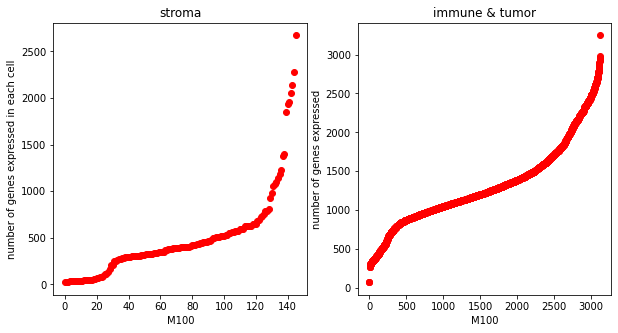

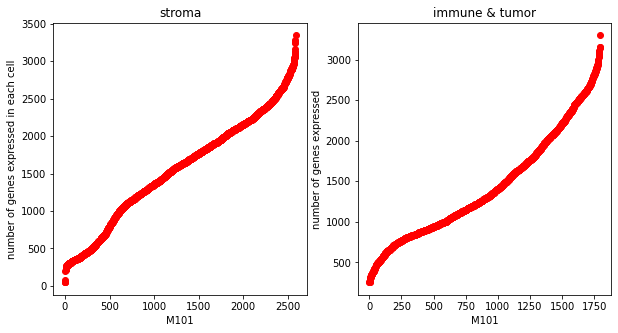

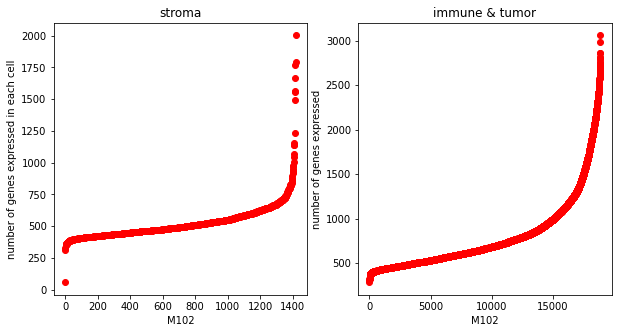

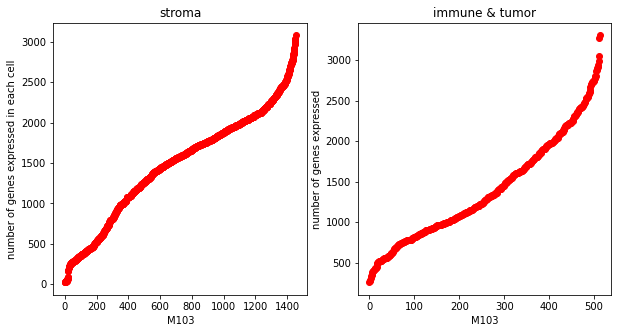

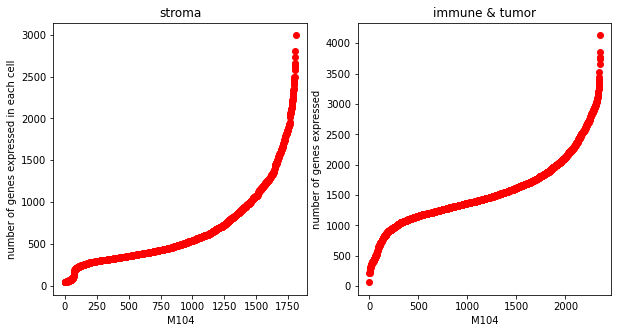

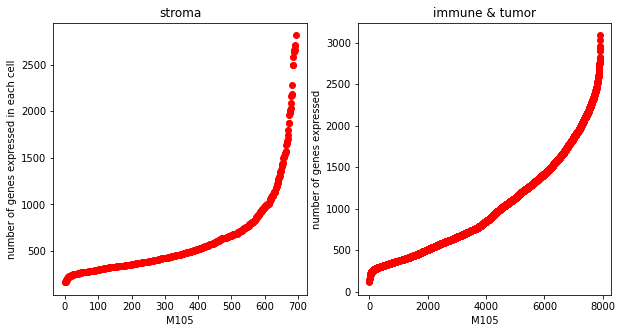

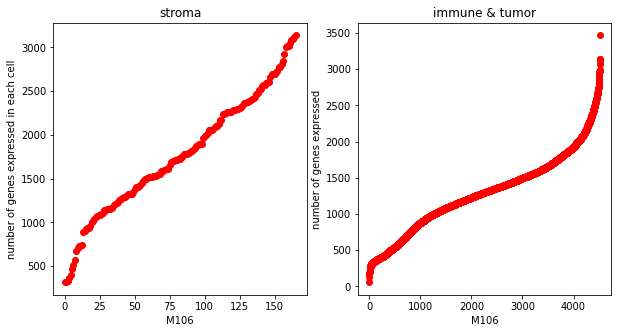

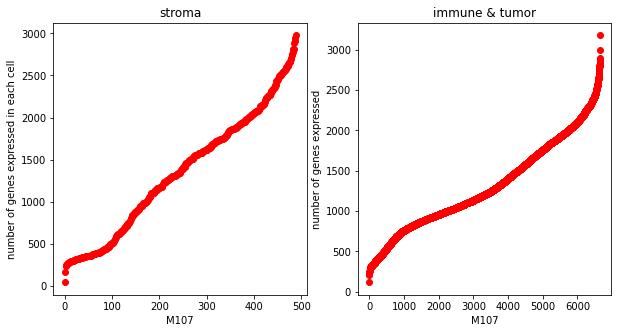

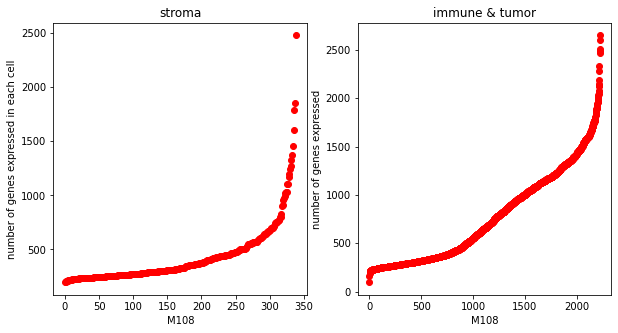

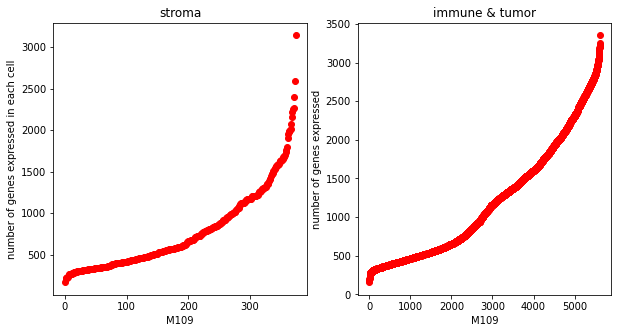

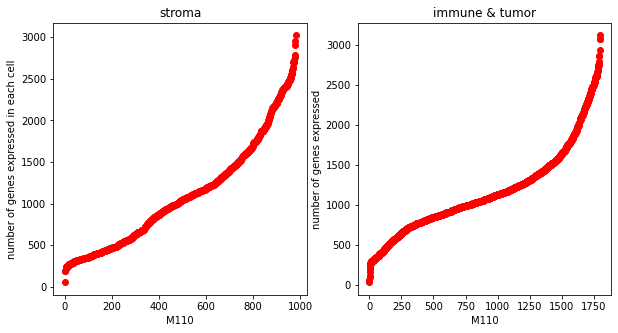

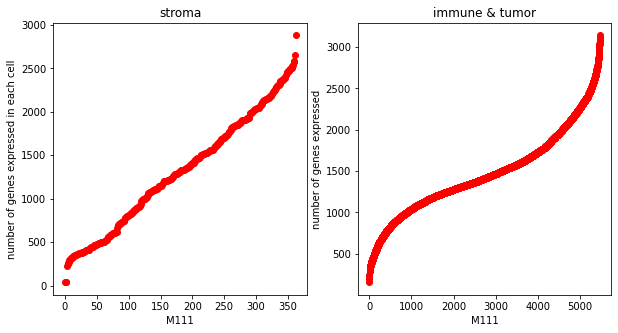

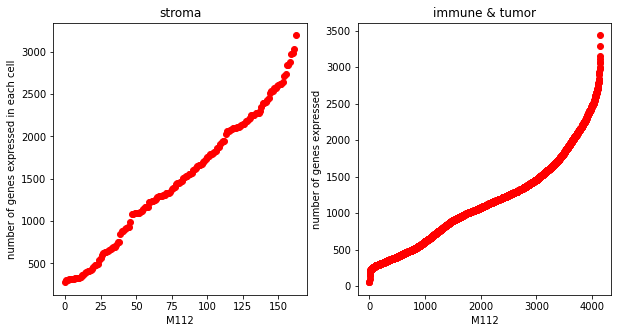

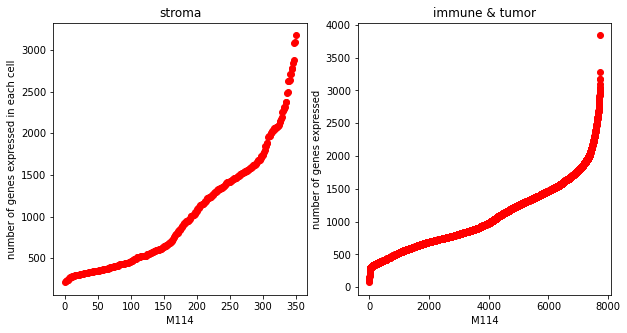

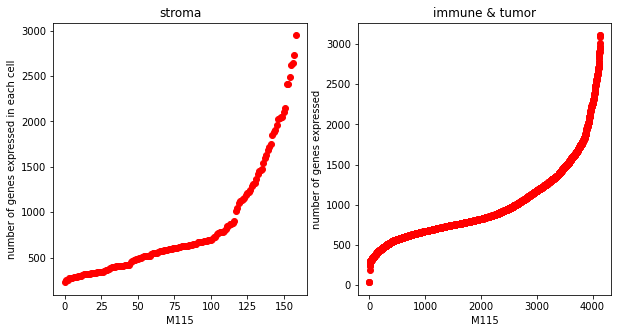

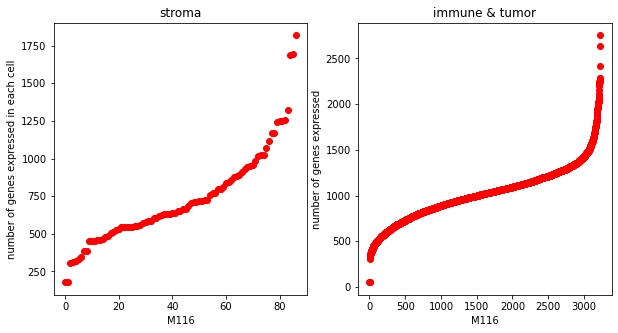

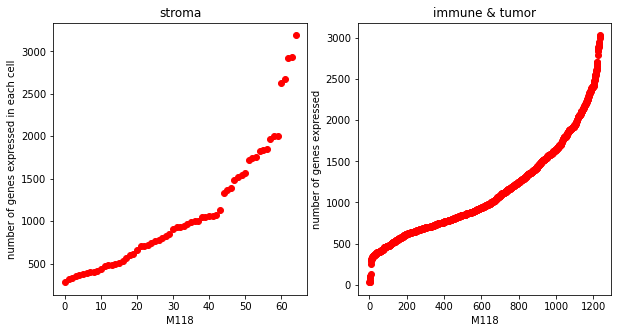

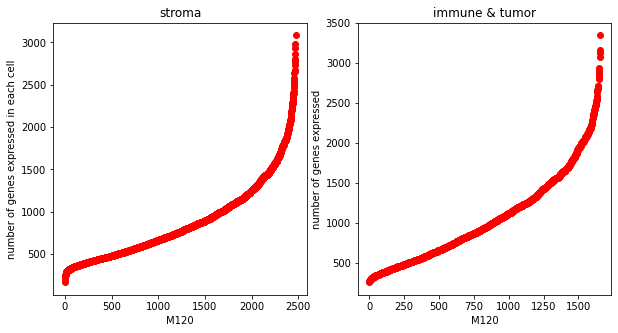

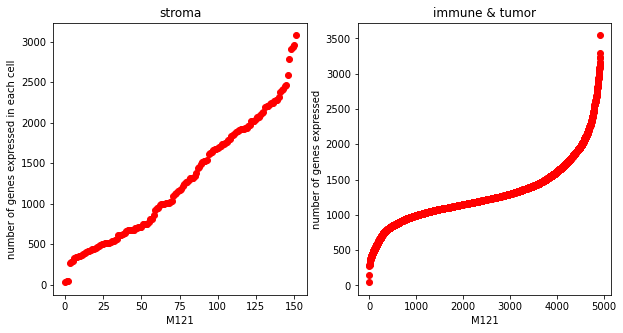

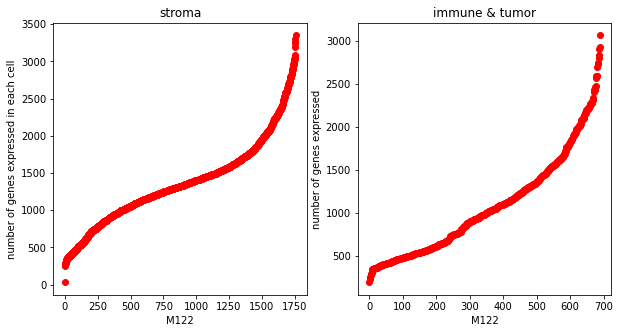

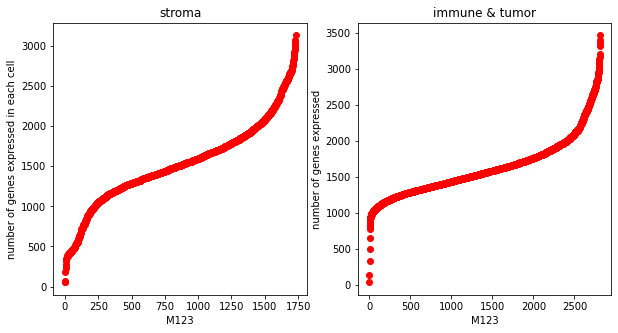

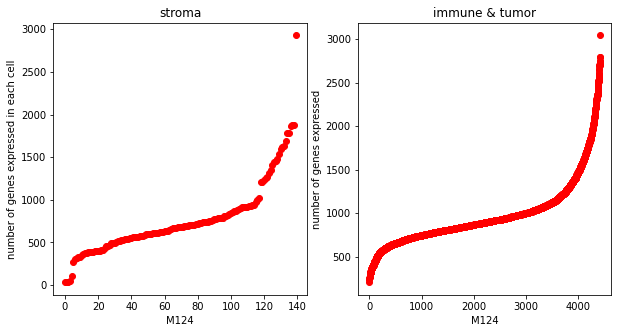

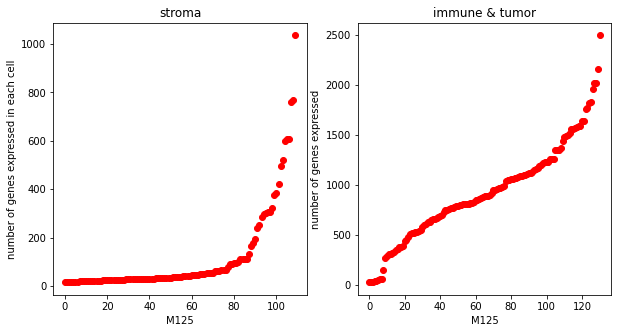

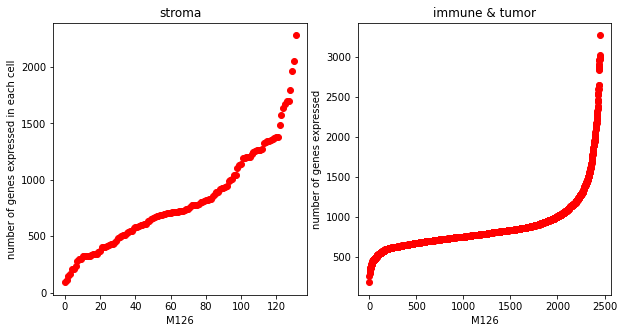

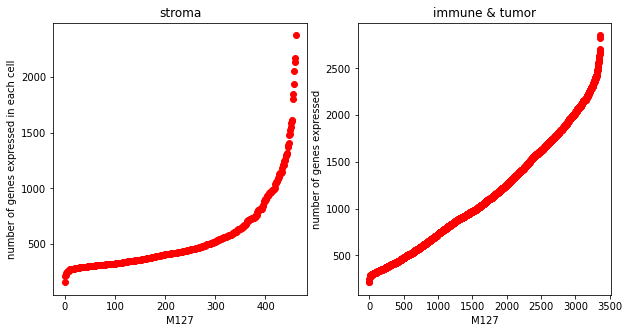

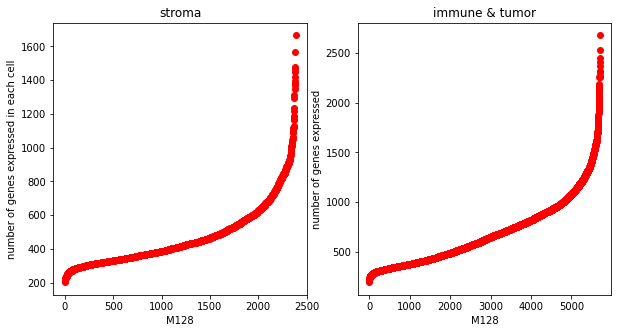

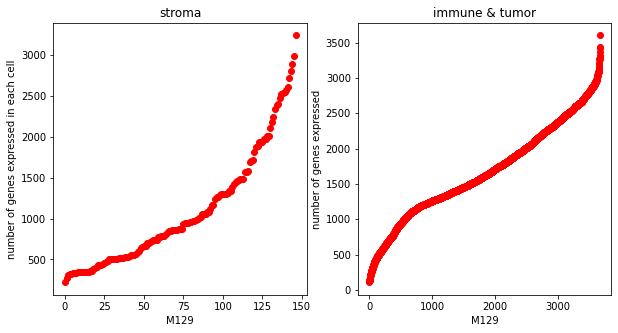

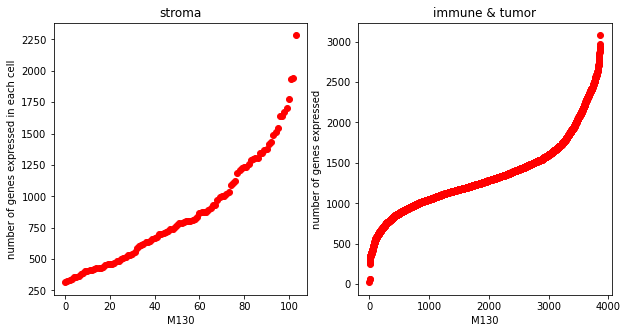

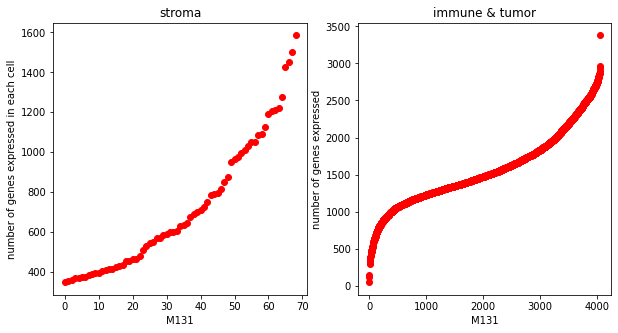

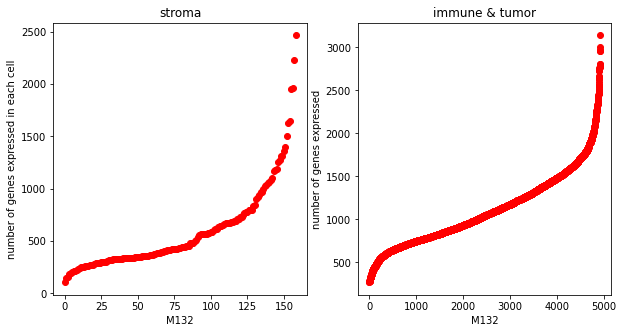

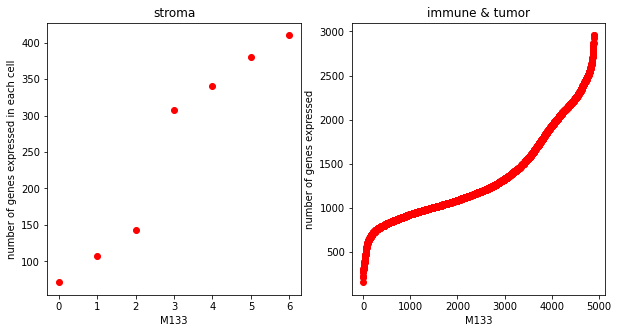

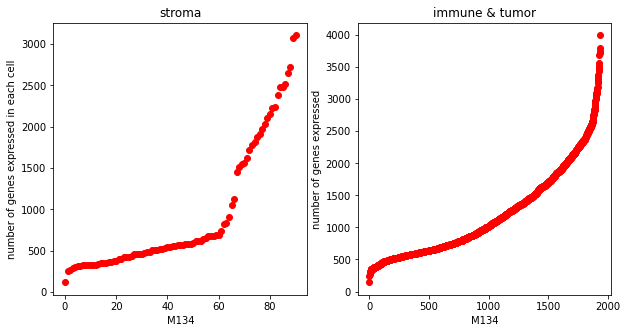

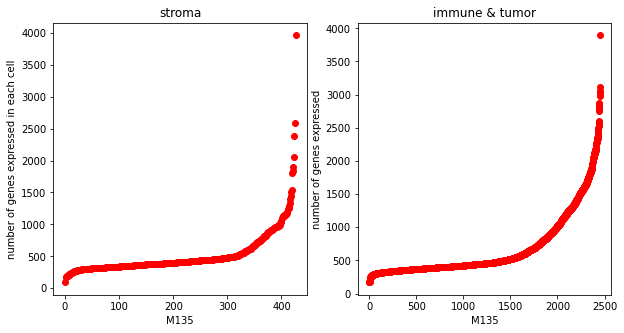

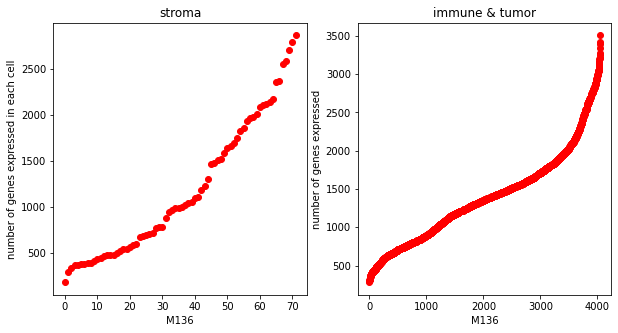

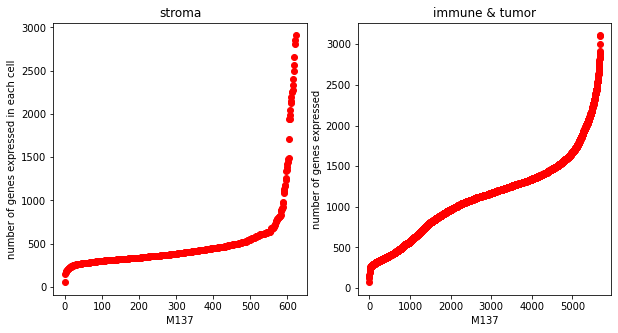

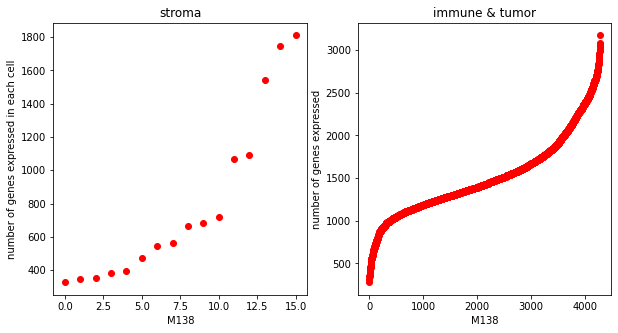

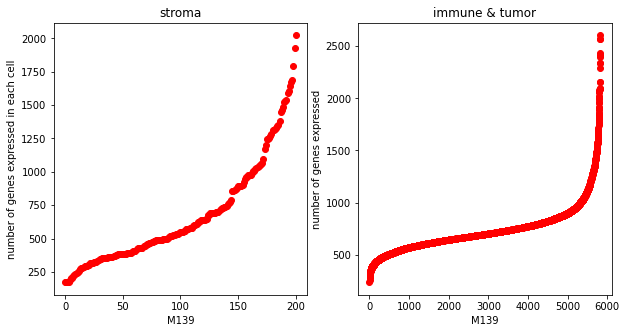

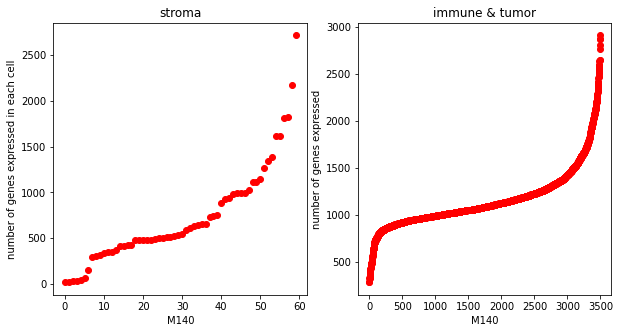

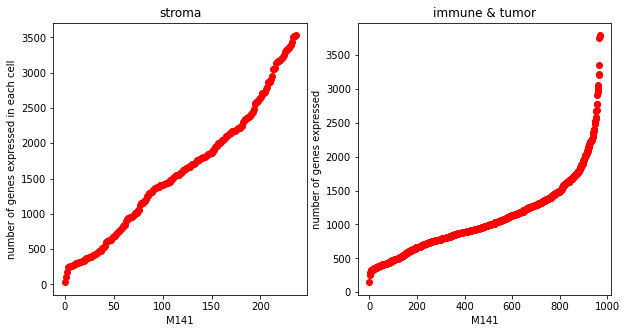

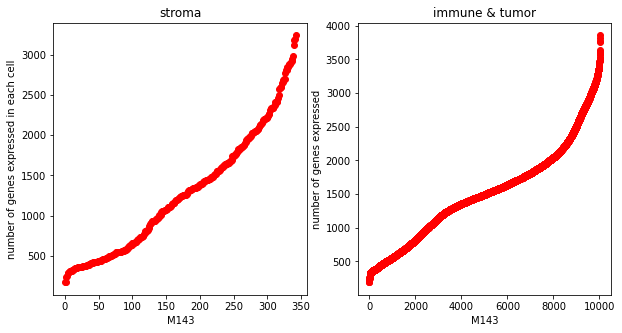

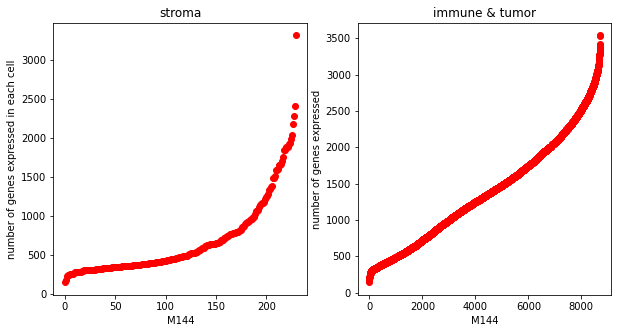

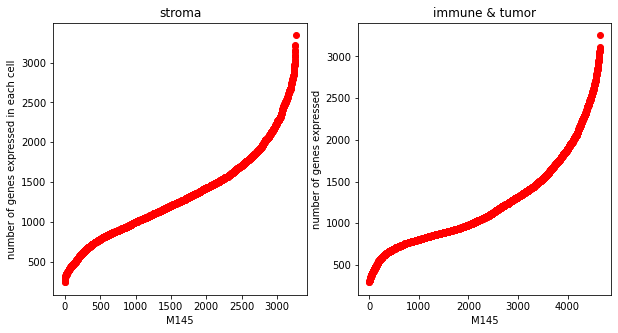

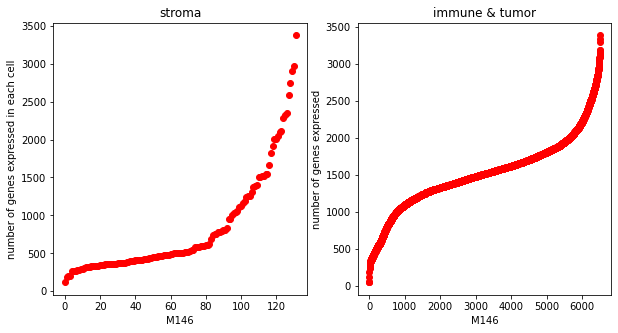

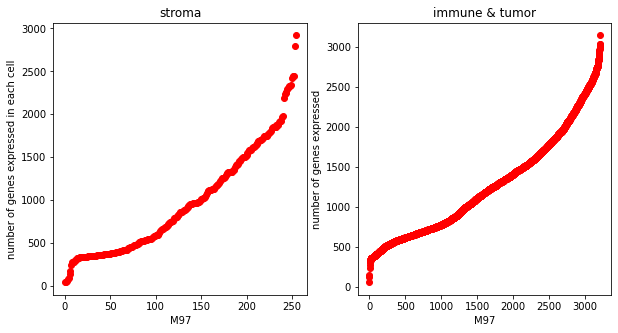

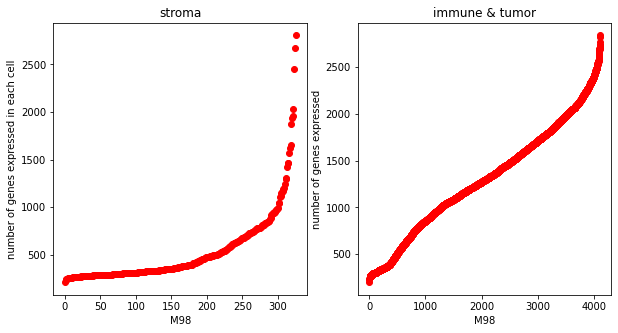

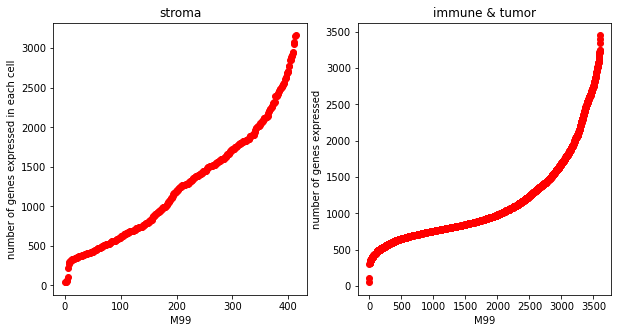

In [15]:
ROW_SAMPLES_PATH = fr'D:\Technion studies\Keren Laboratory\Data\droplet_seq\ROW_DATA'
SAMPLES_INFORMATION_PATH = fr'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\4.3.21'
OUTPUT_PATH = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\QC\genes expressed in stromal cells 4.3.21'
samples = [subfolder for subfolder in os.listdir(ROW_SAMPLES_PATH)]

create_folder(OUTPUT_PATH)
for sample in samples: 
    print(sample)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)


    sample = sample.replace('.pkl', '')


    rna_sample = loading_sample(row_data_path=join(ROW_SAMPLES_PATH, f'{sample}.pkl'), 
                                    cells_information_path=join(SAMPLES_INFORMATION_PATH, f'{sample}.pkl'))
    ###   Remove garbage cells  ###
    rna_sample = rna_sample[[not aa for aa in rna_sample.cells_information.getattr('should_be_removed')]]
    rna_sample.normalize_data()



    # stroma
    stroma = rna_sample.filter_cells_by_property('is_stromal', True)
    ss = (stroma.counts>1).astype(np.int).sum(axis=1)
    # plt.scatter(np.arange(ss.shape[0]), ss[ss.argsort()])
    axs[0].plot(np.arange(ss.shape[0]), ss[ss.argsort()], 'ro')
    axs[0].set_title(f"stroma")
    axs[0].set_ylabel('number of genes expressed in each cell')
    axs[0].set_xlabel(f'{sample}')
    
    # not stroma
    not_stroma = rna_sample.filter_cells_by_property('is_stromal', False)
    ss = (not_stroma.counts>1).astype(np.int).sum(axis=1)
    # plt.scatter(np.arange(ss.shape[0]), ss[ss.argsort()])
    axs[1].plot(np.arange(ss.shape[0]), ss[ss.argsort()], 'ro')
    axs[1].set_title(f"immune & tumor")
    axs[1].set_ylabel('number of genes expressed')
    axs[1].set_xlabel(f'{sample}')
    
    fig.savefig(join(OUTPUT_PATH, rf'{sample}.png'))


# 4. Also, please check which cells express the genes COL1A1 and COL1A2 which are common fibroblast genes, and see if they are generally expressed in cells with a higher gene count

sample id M125.pkl
number of cells 507	number of genes 14842
number of cells:  337
sample id M126.pkl
number of cells 3125	number of genes 19571
number of cells:  2584
sample id M127.pkl
number of cells 5534	number of genes 19989
number of cells:  3819
sample id M128.pkl
number of cells 8331	number of genes 19760
number of cells:  8096
sample id M129.pkl
number of cells 8911	number of genes 22310
number of cells:  4921
sample id M130.pkl
number of cells 5981	number of genes 23986
number of cells:  3965
sample id M131.pkl
number of cells 4722	number of genes 22341
number of cells:  4124
sample id M132.pkl
number of cells 5949	number of genes 22320
number of cells:  5069
sample id M133.pkl
number of cells 5696	number of genes 21458
number of cells:  4954


c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sample id M134.pkl
number of cells 2384	number of genes 20765
number of cells:  2027
sample id M135.pkl
number of cells 3388	number of genes 20499
number of cells:  2913
sample id M136.pkl
number of cells 4872	number of genes 22840
number of cells:  4128
sample id M137.pkl
number of cells 9353	number of genes 21937
number of cells:  7201
sample id M138.pkl
number of cells 4915	number of genes 22020
number of cells:  4300
sample id M139.pkl
number of cells 6260	number of genes 20368
number of cells:  6021
sample id M140.pkl
number of cells 3756	number of genes 20179
number of cells:  3553
sample id M141.pkl
number of cells 1233	number of genes 19642
number of cells:  1207
sample id M143.pkl
number of cells 10992	number of genes 24339
number of cells:  10365
sample id M144.pkl
number of cells 10765	number of genes 22825
number of cells:  9569
sample id M145.pkl
number of cells 8911	number of genes 32738
number of cells:  8073


c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


sample id M146.pkl
number of cells 8281	number of genes 32738
number of cells:  6687
sample id M97.pkl
number of cells 4296	number of genes 21462
number of cells:  3467
sample id M98.pkl
number of cells 5137	number of genes 20626
number of cells:  4566
sample id M99.pkl
number of cells 5093	number of genes 23358
number of cells:  4017


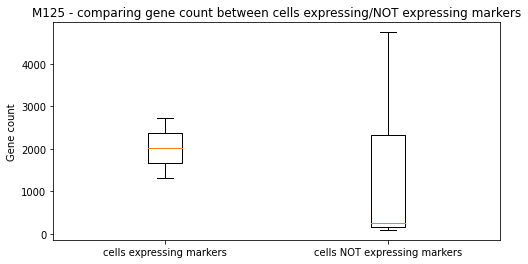

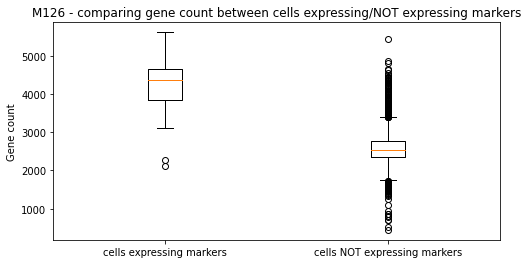

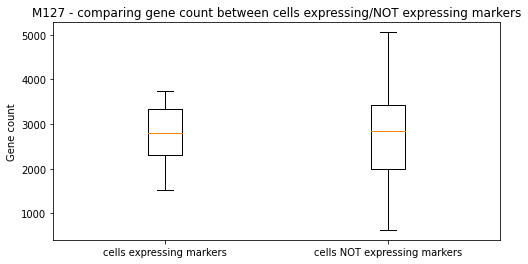

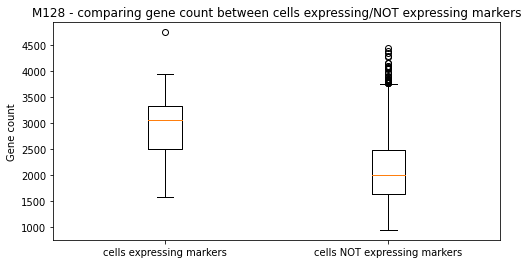

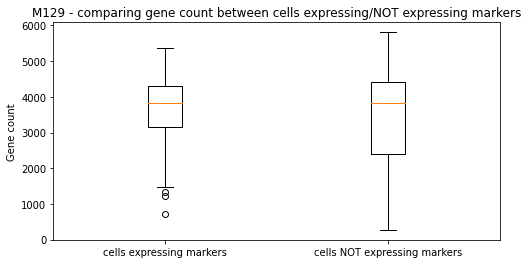

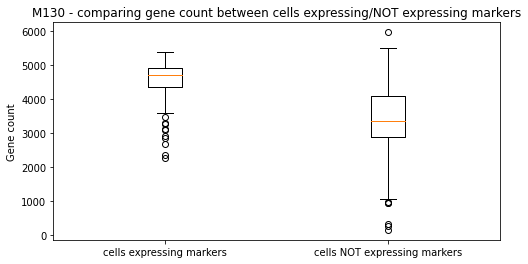

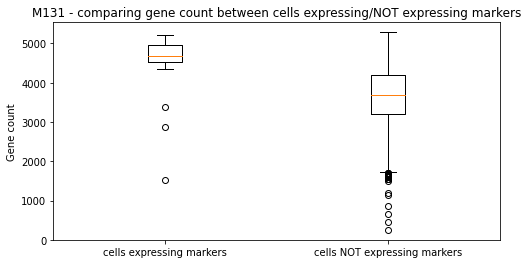

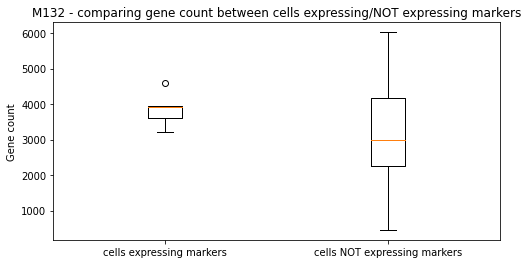

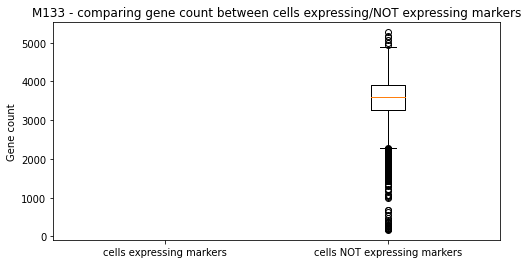

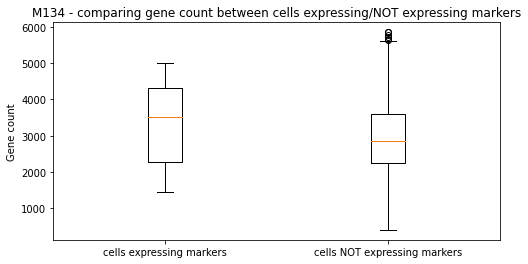

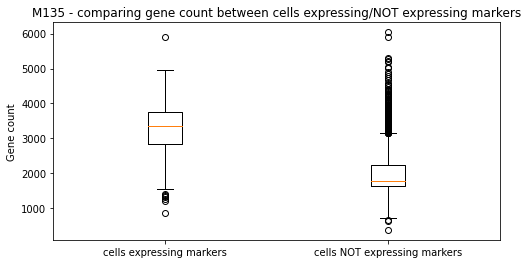

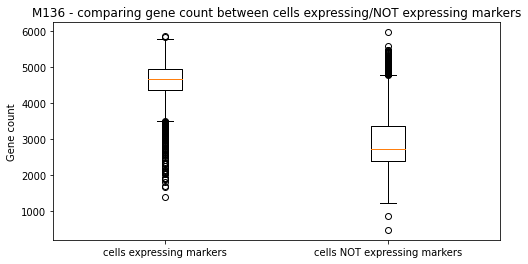

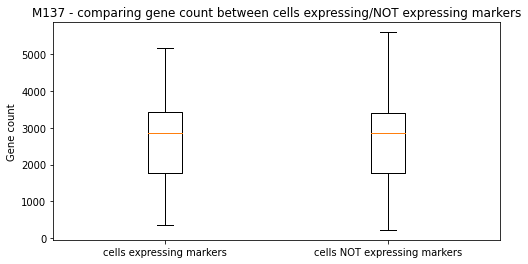

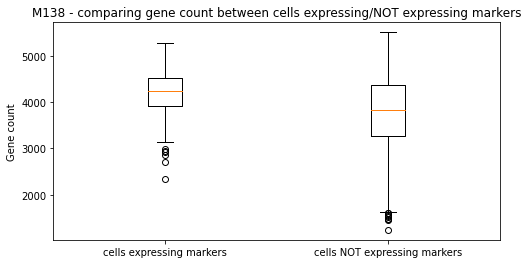

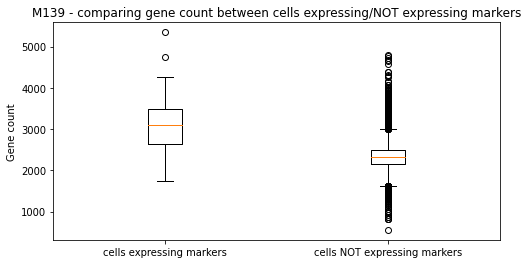

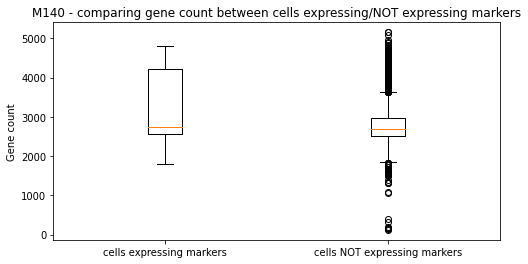

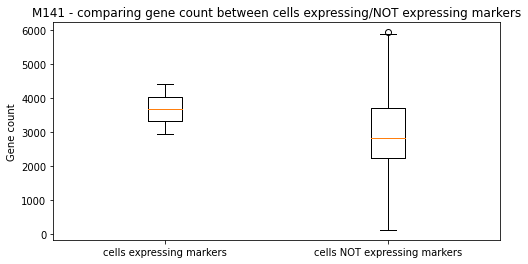

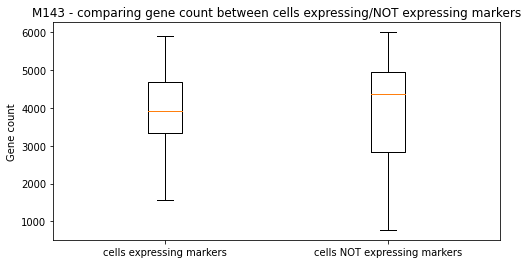

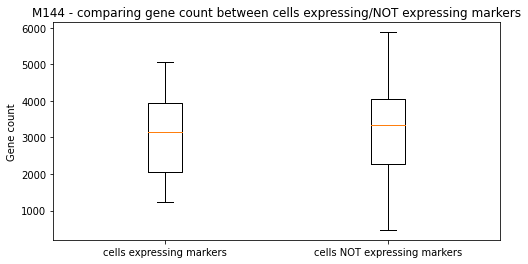

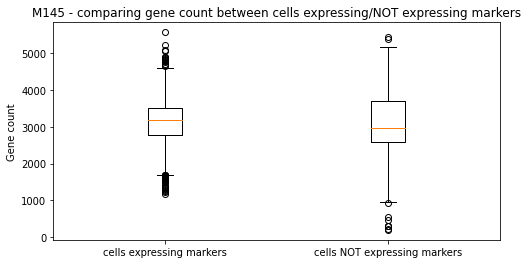

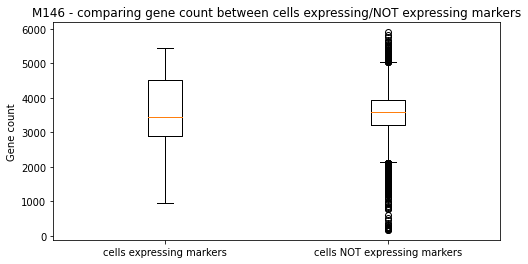

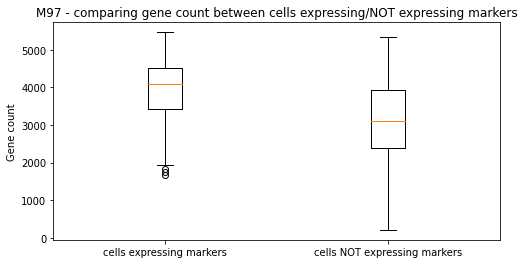

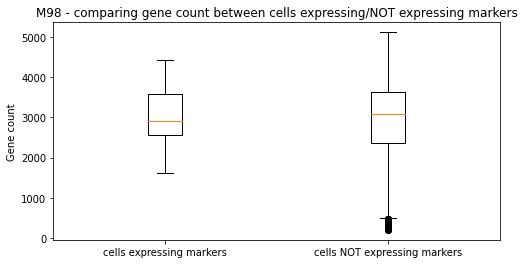

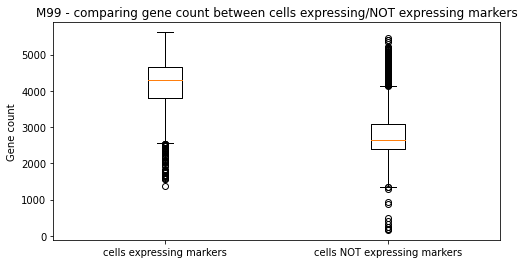

In [233]:
SAMPLES = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\21.2.21'
OUTPUT_PATH = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\QC\analysis - which cells express the genes COL1A1 and COL1A2'

df = pd.DataFrame(columns=["sample", "immune - % of cells expressing the genes COL1A1 and COL1A2",
                      'tumor - %',
                      'stroma - %',
                      'mean gene count - expressing cells',
                      'mean gene count - NOT expressing cells',
                      'median gene count - expressing cells',
                      'median gene count - NOT expressing cells'])

samples = [subfolder for subfolder in os.listdir(SAMPLES)]
# create_folder(OUTPUT_PATH)
for sample in samples[22:]:
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)
    # Extracts one of the samples from PC
    rna_sample = extract_sample(sample)
    rna_sample = rna_sample.filter_cells_by_property('should_be_removed', False)
    print("number of cells: ",rna_sample.number_of_cells)
    _rna_sample = RNAseq_Sample(counts=rna_sample.counts, gene_names=rna_sample.gene_names, barcodes=rna_sample.barcodes, 
                        features=rna_sample.features, cells_information=rna_sample.cells_information)
    rna_sample = _rna_sample
    rna_sample.normalize_data()
    
    col1_idx  = rna_sample.gene_names.index('COL1A1')
    if 'COL1A2' in rna_sample.gene_names: 
        col2_idx  = rna_sample.gene_names.index('COL1A2')
    else:
        col2_idx  = col1_idx

    sub_rna_sample = rna_sample[np.any(rna_sample.counts[:, [col1_idx, col2_idx]]>1, axis=1).tolist()]

    
#     print("cancer %: ", sub_rna_sample.filter_cells_by_property('is_cancer', True).number_of_cells/rna_sample.filter_cells_by_property('is_cancer', True).number_of_cells)
#     print("immune %: ", sub_rna_sample.filter_cells_by_property('is_immune', True).number_of_cells/rna_sample.filter_cells_by_property('is_immune', True).number_of_cells)
#     print("stromal %: ", sub_rna_sample.filter_cells_by_property('is_stromal', True).number_of_cells/rna_sample.filter_cells_by_property('is_stromal', True).number_of_cells)


    cells_with_marker_idx = np.any(rna_sample.counts[:, [col1_idx, col2_idx]]>1, axis=1).tolist()
    cells_no_marker_idx = (np.any(rna_sample.counts[:, [col1_idx, col2_idx]]>1, axis=1)!=True).tolist()

    dist_markers = rna_sample[cells_with_marker_idx].counts.sum(axis=1)
    dist_no_markers = rna_sample[cells_no_marker_idx].counts.sum(axis=1)

    axs.boxplot([dist_markers, dist_no_markers], labels=["cells expressing markers", "cells NOT expressing markers"])
    axs.set_title(f"{sample.replace('.pkl', '')} - comparing gene count between cells expressing/NOT expressing markers")
    axs.set_ylabel('Gene count')

    df = df.append(pd.DataFrame([[sample.replace('.pkl', ''),
                                  sub_rna_sample.filter_cells_by_property('is_immune', True).number_of_cells/rna_sample.filter_cells_by_property('is_immune', True).number_of_cells,
                                  sub_rna_sample.filter_cells_by_property('is_cancer', True).number_of_cells/rna_sample.filter_cells_by_property('is_cancer', True).number_of_cells,
                                  sub_rna_sample.filter_cells_by_property('is_stromal', True).number_of_cells/rna_sample.filter_cells_by_property('is_stromal', True).number_of_cells,
                                  np.mean(dist_markers), 
                                  np.mean(dist_no_markers), 
                                  np.median(dist_markers), 
                                  np.median(dist_no_markers)]], columns=df.columns))
    
#     print(np.mean(dist_markers))
#     print(np.mean(dist_no_markers))
#     print(np.median(dist_markers))
#     print(np.median(dist_no_markers))
    fig.savefig(join(OUTPUT_PATH, f'{sample.replace(".pkl", "")}.png'))

df.to_excel(join(OUTPUT_PATH, 'expressing_genes_COL1A1&COL1A2.xlsx'), index=False)

# DEBUG
Checking scaling factor for normalization, 10K or 100K or 1M. for what values we will get number under zerows after normalization be done.

In [ ]:
SAMPLES = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\21.2.21'


samples = [subfolder for subfolder in os.listdir(SAMPLES)]
for sample in [s for s in samples if not 'csv' in s]:
    # Extracts one of the samples from PC
    rna_sample = extract_sample(sample)    
    #10K ----------------------------------------------------------
    sum_cells = rna_sample.counts.sum(axis=1)  # for each cell
    scaling_factors = sum_cells / 10000

    normalized_cells = np.log2((rna_sample.counts / scaling_factors[:, None]+1))
    normalized_cells[np.isneginf(normalized_cells)] = 0
    checked = normalized_cells.flatten()
    # plt.boxplot(checked.flatten())
    print("10K")
    print(checked[checked<0].shape)
    print("max", checked.max())
    print("min", checked.min())
    print("mean", checked.mean())
    print("median", np.median(checked))
    
    #100K ----------------------------------------------------------
#     sum_cells = rna_sample.counts.sum(axis=1)  # for each cell
#     scaling_factors = sum_cells / 100000 

#     normalized_cells = np.log2((rna_sample.counts / scaling_factors[:, None]+1))
#     normalized_cells[np.isneginf(normalized_cells)] = 0
#     checked = normalized_cells.flatten()
#     # plt.boxplot(checked.flatten())
#     print("100K")
#     print(checked[checked<0].shape)
#     print("max", checked.max())
#     print("min", checked.min())
#     print("mean", checked.mean())
#     print("median", np.median(checked))
    
    
    
    #1M ----------------------------------------------------------
#     sum_cells = rna_sample.counts.sum(axis=1)  # for each cell
#     scaling_factors = sum_cells / 1000000 # 1M

#     normalized_cells = np.log2((rna_sample.counts / scaling_factors[:, None])+1)
#     normalized_cells[np.isneginf(normalized_cells)] = 0
#     checked = normalized_cells.flatten()
#     # plt.boxplot(checked.flatten())
#     print("1m")
#     print(checked[checked<0].shape)
#     print("max", checked.max())
#     print("min", checked.min())
#     print("mean", checked.mean())
#     print("median", np.median(checked))

sample id M100.pkl
number of cells 4055	number of genes 20765
10K
(0,)
max 13.226223872883084
min 0.0
mean 0.1506183596998354
median 0.0
sample id M101.pkl
number of cells 5141	number of genes 22423
10K
(0,)
max 13.166190779643356
min 0.0
mean 0.15396876952160946
median 0.0
sample id M102.pkl
number of cells 22694	number of genes 21324
10K
(0,)
max 13.081189048946817
min 0.0
mean 0.11361650865938058
median 0.0
sample id M103.pkl
number of cells 2453	number of genes 20400
10K
(0,)
max 13.178513863263374
min 0.0
mean 0.14062733792172322
median 0.0
sample id M104.pkl
number of cells 4944	number of genes 23198
10K
(0,)
max 13.136256367046531
min 0.0
mean 0.12822876696023436
median 0.0
sample id M105.pkl
number of cells 14312	number of genes 22537
10K
(0,)
max 12.007954786614464
min 0.0
mean 0.0982762828984782
median 0.0
sample id M106.pkl
number of cells 5136	number of genes 22752
10K
(0,)
max 12.285803773761359
min 0.0
mean 0.1537415394825827
median 0.0
sample id M107.pkl
number of cells 

In [199]:
### proportion test 

from statsmodels.stats.proportion import proportions_ztest
count = sum(is_stromal) #12
nobs = len(is_stromal) #180
value = sum(cnv_rna_sample.cells_information.getattr('is_stromal'))/cnv_rna_sample.number_of_cells
proportions_ztest(count, nobs, value, alternative='two-sided')


C:\Users\itay\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\proportion.py:840: RuntimeWarning: invalid value encountered in double_scalars
  prop = count * 1. / nobs
C:\Users\itay\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\proportion.py:854: RuntimeWarning: invalid value encountered in double_scalars
  p_pooled = np.sum(count) * 1. / np.sum(nobs)
C:\Users\itay\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\proportion.py:856: RuntimeWarning: divide by zero encountered in true_divide
  nobs_fact = np.sum(1. / nobs)
c:\users\itay\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(nan, nan)

In [23]:
l = [(4, 10), (6, 18), (6, 18), (3, 13)]

# sorted(l, key=lambda x: x[1])
list(set(l))

[(4, 10), (6, 18), (3, 13)]

In [236]:
l2 = [1,2,3]
list(zip(l2, l2))

[(1, 1), (2, 2), (3, 3)]

In [237]:
SAMPLES = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\21.2.21'


samples = [subfolder for subfolder in os.listdir(SAMPLES)]
# Extracts one of the samples from PC
rna_sample = extract_sample('M101.pkl')
rna_sample = rna_sample.filter_cells_by_property('should_be_removed', False)
print("number of cells: ",rna_sample.number_of_cells)
_rna_sample = RNAseq_Sample(counts=rna_sample.counts, gene_names=rna_sample.gene_names, barcodes=rna_sample.barcodes, 
                    features=rna_sample.features, cells_information=rna_sample.cells_information)
rna_sample = _rna_sample
rna_sample.normalize_data()

sample id M101.pkl
number of cells 5141	number of genes 22423
number of cells:  4386


1

In [240]:
sum(rna_sample.cells_information.getattr('is_cancer'))

410